In [1]:
import os
import sys
import mne
import matplotlib as plt
import sleepeegpy
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import yasa

import mne
import numpy as np
import pooch
from sleepeegpy.pipeline import (
    CleaningPipe,
    ICAPipe,
    SpectralPipe,
    SpindlesPipe,
    SlowWavesPipe,
    RapidEyeMovementsPipe,
)
from sleepeegpy.dashboard import create_dashboard

from os import makedirs

# Load EEG file (modify the filename)
raw = mne.io.read_raw_edf("2025-02-18_23-51-08_1a6055f0_27_electrodes.edf", preload=True)

# # Apply bandpass and notch filtering
raw.filter(l_freq=0.75, h_freq=40, picks="eeg")  # Bandpass: 0.75-40 Hz
raw.notch_filter(freqs=50, picks="eeg")  # Remove 50Hz powerline noise

# # Detect bad segments automatically
epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
stds = np.std(epochs.get_data(), axis=(1, 2))
threshold = np.mean(stds) + 2 * np.std(stds)
bad_epochs = np.where(stds > threshold)[0]

# # Annotate detected bad segments
for epoch_idx in bad_epochs:
    onset = epochs.events[epoch_idx, 0] / raw.info['sfreq']
    #buffer_time = 1.5  # Adjust as needed
    #onset_corrected = onset - buffer_time
    raw.annotations.append(onset, 3, "BAD")



Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/sleepeeg/2025-02-18_23-51-08_1a6055f0_27_electrodes.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8839679  =      0.000 ... 34529.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1127 samples (4.402 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Not setting metadata
17265 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17265 events and 512 original time points ...
0 bad epochs dropped


In [ ]:
fig = raw.plot()

In [2]:
print(raw.info)
print(raw.annotations.description)  # The names of the annotations
print(raw.annotations.onset)        # The time (in seconds) when they occur
print(raw.annotations.duration) 

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, TP7, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.8 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-02-18 23:51:08 UTC
 nchan: 30
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>
['REC_STARTED ' 'Missing 1 samples / 0,00 seconds'
 'Missing 1 samples / 0,00 seconds' ... 'BAD' 'BAD' 'REC_HALTED ']
[8.59000000e-02 2.22556000e+02 2.48941000e+02 ... 3.41680000e+04
 3.41700000e+04 3.44691649e+04]
[0. 0. 0. ... 3. 3. 0.]


In [3]:
output_dir = "output_folder"  # Output path and name can be changed here
input_dir = "input_files"  # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

subject_code = "Sub 02" # The subject code that will appear in the dashboard
bad_channels = "bad_channels.txt"
annotations = "annotations.txt"
hypnogram_filename = "staging.txt"
hypno_freq = 1  # If required, change the Hypnogram's sampling frequency (Visbrain's hypnograms default to 1)
hypno_selection = "automatically"
annotations_selection = "from-file"
bad_channels_selection = "automatically"

if hypno_selection == "automatically":
    hypnogram_path = "predict"
    #### If you selected automatic hypnogram, select prediction arguments. ####
    hypno_predict_arguments = {
        "eeg_name": "C4", #(C4)
        "eog_name": None, #(EOG1)
        "emg_name": None,
        "ref_name" : "Cz",
    }
else:
    hypno_predict_arguments = None

n_components = 25 # initial was 30
picked_channel = "Pz"  # (Pz)
loc_chname = "R1"  # (EOG1)
roc_chname = "R2"  # (EOG2)

#path_to_eeg = os.path.join(input_dir, eeg_file)
if hypno_selection == "from-file":
    hypnogram_path = os.path.join(input_dir, hypnogram_filename)
bad_channels = (
    None if bad_channels_selection == "automatically" else os.path.join(input_dir, bad_channels))
annotations = ( None if annotations_selection == "automatically" else os.path.join(input_dir, annotations))

## 1. Cleaning

In [11]:
path_to_eeg = os.path.join(input_dir, "2025-02-18_23-51-08_1a6055f0_27_electrodes.edf")
pipe = CleaningPipe(path_to_eeg=path_to_eeg, output_dir=output_dir)
# start_time = 18000
# pipe.mne_raw.crop(tmin=start_time)

# Apply bandpass and notch filtering
pipe.resample(sfreq=256, n_jobs=-1, verbose=False)
pipe.filter(l_freq=0.75, h_freq=40, n_jobs=-1,) # Bandpass
pipe.notch(freqs=50, n_jobs=-1,) #Notch

Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/sleepeeg/input_files/2025-02-18_23-51-08_1a6055f0_27_electrodes.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8839679  =      0.000 ... 34529.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1127 samples (4.402 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


In [12]:
# Detect bad segments automatically
epochs = mne.make_fixed_length_epochs(pipe.mne_raw, duration=2)
stds = np.std(epochs.get_data(), axis=(1, 2))
threshold = np.mean(stds) + 2 * np.std(stds)
bad_epochs = np.where(stds > threshold)[0]

# # Annotate detected bad segments
for epoch_idx in bad_epochs:
    onset = epochs.events[epoch_idx, 0] / pipe.mne_raw.info['sfreq']
    pipe.mne_raw.annotations.append(onset, 2, "BAD")

Not setting metadata
17265 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17265 events and 512 original time points ...
0 bad epochs dropped


In [6]:
fig = pipe.mne_raw.plot()
print(pipe.mne_raw.annotations)

Using qt as 2D backend.
Using pyopengl with version 3.1.9
<Annotations | 992 segments: BAD (292), Missing 1 samples / 0,00 seconds ...>


Channels marked as bad:
none


In [13]:
# Load a standard 10-20 montage
montage = mne.channels.make_standard_montage("standard_1020")

# Get only the channels that exist in the montage
valid_channels = [ch for ch in pipe.mne_raw.ch_names if ch in montage.ch_names]
pipe.mne_raw.pick_channels(valid_channels)

# Apply montage
pipe.mne_raw.set_montage(montage)

# Now run bad channel detection
#bad_channels = pipe.auto_detect_bad_channels()

pipe.mne_raw.info

pipe.set_eeg_reference(ref_channels="average", projection=True)

if bad_channels_selection == "manually":
    pipe.plot(save_bad_channels=True)
elif bad_channels_selection == "automatically":
    bad_channels = pipe.auto_detect_bad_channels()

pipe.read_bad_channels(path=None if bad_channels_selection == "Manually" else bad_channels)

pipe.interpolate_bads(reset_bads=True)

if annotations_selection == "manually":
    pipe.plot(butterfly=True, save_annotations=True, overwrite=True)
    pipe.read_annotations()
elif annotations_selection == "from-file":
    pipe.read_annotations(path=annotations)
elif annotations_selection == "automatically":
    pipe.auto_set_annotations()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/41 [00:00<?,       ?it/s]


RANSAC done!
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/6864 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.3 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 6 sensors


Interpolated channels: ['T8', 'F4', 'T10', 'Fz', 'T9', 'P7']


In [8]:
# recording_start = pipe.mne_raw.info["meas_date"]  # Get actual recording datetime
# if isinstance(recording_start, tuple):  # MNE sometimes returns a tuple
#     recording_start = recording_start[0]

# # Convert to datetime format (if needed)
# if isinstance(recording_start, float):
#     recording_start = datetime.datetime.utcfromtimestamp(recording_start)

# print(f"Recording started at: {recording_start}")

# crop_offset = 18000  # The EEG was cropped at 20,000 sec
# new_start_time = recording_start + datetime.timedelta(seconds=crop_offset)

# print(f"Adjusted Recording Start (After Cropping): {new_start_time}")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


average reference has been applied


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.
Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.


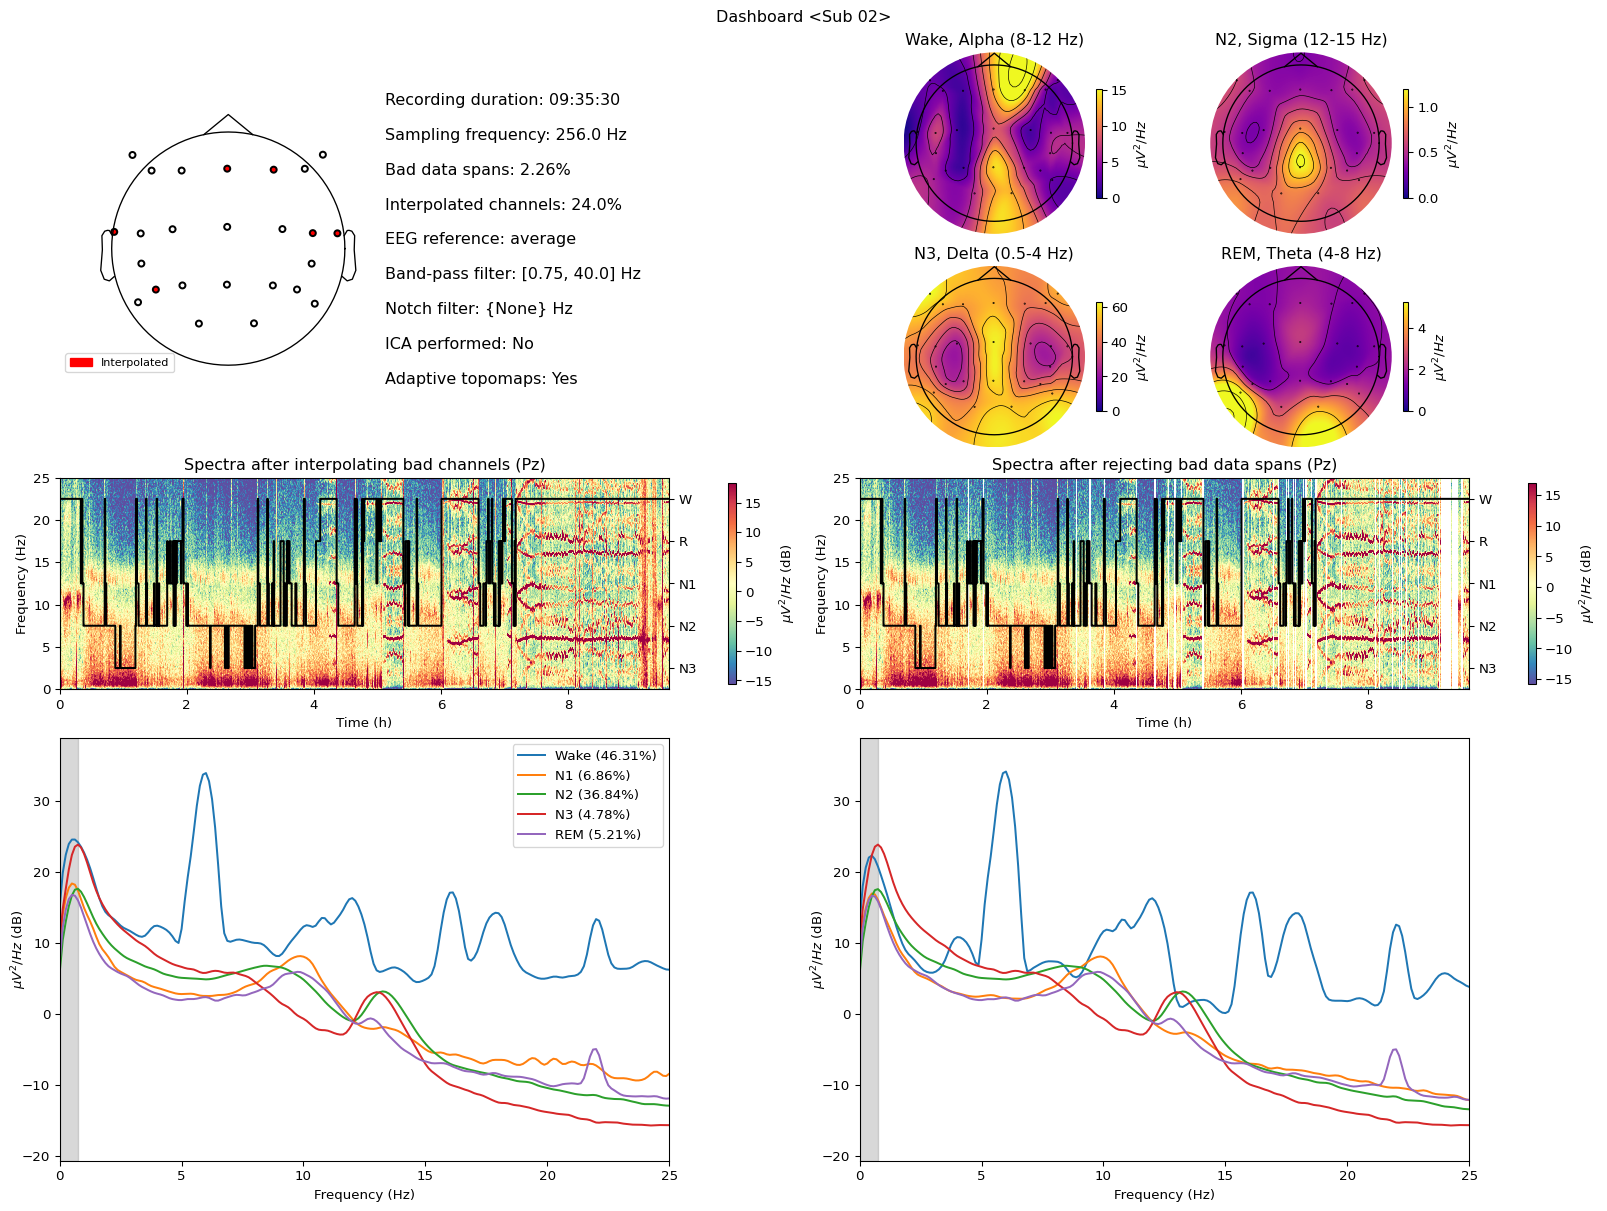

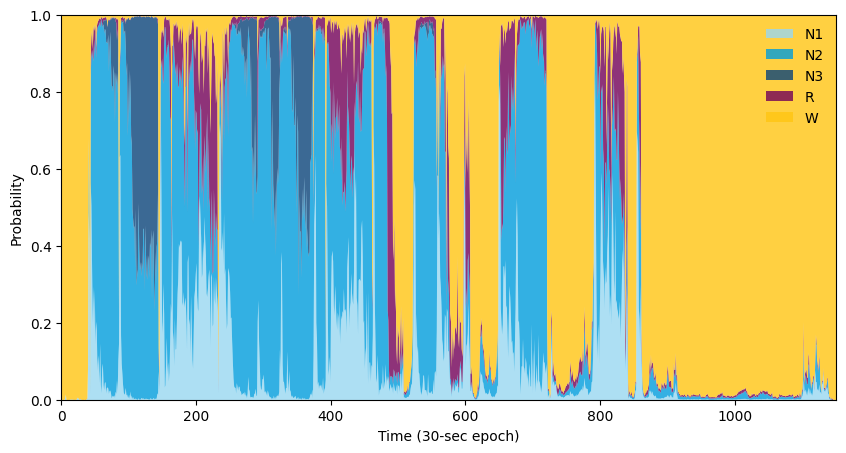

In [14]:
fig = create_dashboard(
    subject_code=subject_code,
    prec_pipe=pipe,
    hypno_psd_pick=picked_channel,
    hypnogram=hypnogram_path,
    predict_hypno_args=hypno_predict_arguments,
    hypno_freq=hypno_freq,
    reference="average",
)

## 2. Spectral

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


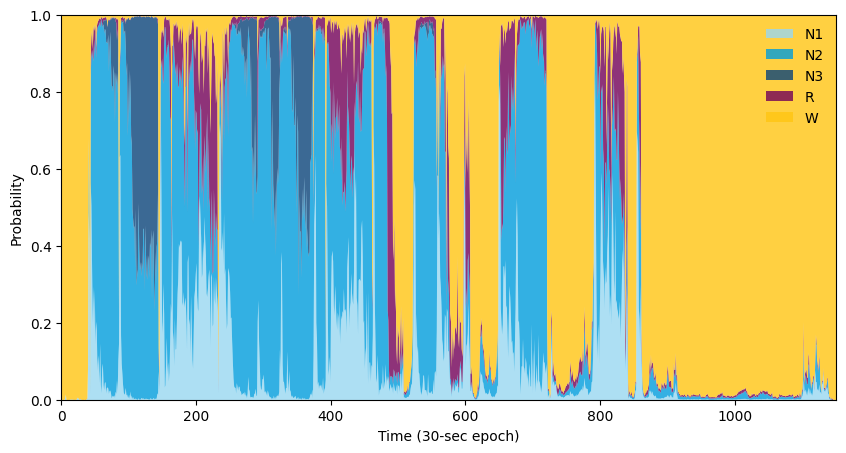

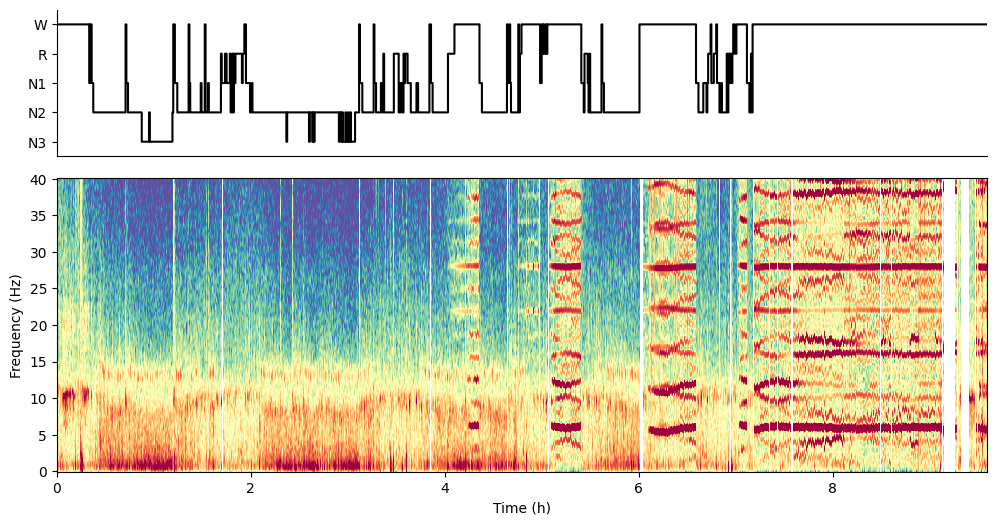

In [15]:
if hypnogram_path and hypnogram_path!="predict":
    spectral_pipe = SpectralPipe(prec_pipe=pipe,path_to_hypno=hypnogram_path,hypno_freq=hypno_freq)
else:
    spectral_pipe = SpectralPipe(prec_pipe=pipe)

if hypnogram_path is None or hypnogram_path=="predict":
    spectral_pipe.predict_hypno(
    eeg_name = hypno_predict_arguments["eeg_name"],
    eog_name = hypno_predict_arguments["eog_name"],
    emg_name =  hypno_predict_arguments["emg_name"],
    ref_name = hypno_predict_arguments["ref_name"],
    save=True)

spectral_pipe.plot_hypnospectrogram(picks=[picked_channel],save=True)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 200192 of 8839680 (2.26%) samples to NaN, retaining 8639488 (97.74%) samples.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size

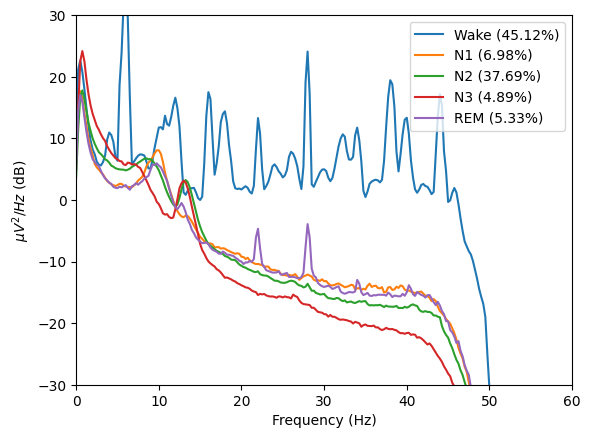

In [16]:
spectral_pipe.compute_psd(
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    reference="average",
    # Additional arguments passed to the Welch method:
    n_fft=1024,
    n_per_seg=1024,
    n_overlap=512,
    window="hamming",
    verbose=True,
    save=False,
)
spectral_pipe.plot_psds(picks=[picked_channel], psd_range=(-30, 30),save=True)